# Project: Hospital Appointment Attendance

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#scheduleDate">Schedule Date</a></li>
<li><a href="#nb_age">Age</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> The dataset explored in this project includes information about hospital appointments that were scheduled in Brazil. The dataset is supplemented with information on the patient's health history and general background, as well as whether or not they attended their appointment.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling


In [4]:
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


Here we have a DataFrame, which includes a patient identifier, appointment information, information of patient health, as well as whether or not they attended their scheduled appointment.

Next, I want to see if the dataset requires any rough cleaning. I would drop rows with null values, but it doesn't appear that this dataset has any.

In [5]:
df[df.isna().any(axis=1)]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show


### Data Cleaning

> The data doesn't contain any null cells, which is great. The only things that I want to do to make analysis a little easier is:
1. Expand the patient ID to make it easier to query
2. Rename the entries in the No-Show column from 'No' and 'Yes' to 'Attended' and 'Missed'
3. Split the 'ScheduledDay' and 'Appointment Day' columns into 'Date' and 'Time' columns

#### 1. Change the Patient ID to an object

In [6]:
df['PatientId'].dtypes

dtype('float64')

In [7]:
df['PatientId'] = df['PatientId'].astype(str)
df.head(1)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,29872499824296.0,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No


#### 2. Change 'No-Show' entries

In [8]:
df['No-show'].replace({'No': 'Attended', 'Yes': 'Missed'}, inplace = True)
df['No-show'][0:3]

0    Attended
1    Attended
2    Attended
Name: No-show, dtype: object

#### 3. Split the Date/Time columns into two separate Date and Time columns

In [9]:
df[['Scheduled Date', 'Scheduled Time']] = df['ScheduledDay'].str.split('T', expand=True)
df[['Appointment Date', 'Appointment Time']] = df['AppointmentDay'].str.split('T', expand=True)
df.head(1)

#If you scroll to the right, you should see the added Date and Time columns inserted into the DataFrame

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Scheduled Date,Scheduled Time,Appointment Date,Appointment Time
0,29872499824296.0,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,Attended,2016-04-29,18:38:08Z,2016-04-29,00:00:00Z


In [10]:
df['Appointment Time'].unique()

array(['00:00:00Z'], dtype=object)

It doesn't appear that any time information was kept for the appointments, so we might as well drop that column. While we're at it, we can drop the ScheduledDay and Appointment Day columns, since we now have that information in other columns.

In [11]:
df.drop(columns=['Appointment Time', 'ScheduledDay', 'AppointmentDay'], inplace=True)
df.head(1)

,PatientId,AppointmentID,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Scheduled Date,Scheduled Time,Appointment Date
0,29872499824296.0,5642903,F,62,JARDIM DA PENHA,0,1,0,0,0,0,Attended,2016-04-29,18:38:08Z,2016-04-29


The very last thing I want to do for this step is make a 'Day' column that gives me the actual day of the week associated with each scheduled date and appointment date.

In [12]:
# Step 1: Use the pandas to_datetime function
df['Scheduled Date'] = pd.to_datetime(df['Scheduled Date'])
df['Scheduled Time'] = pd.to_datetime(df['Scheduled Time'])

# Step 2: Create a scheduledDow (scheduled Day of Week) column that uses the date given in the format YYYY-DD-MM and 
# changes it to a numeric value that codes for days of the week, where 0 is Monday and 6 is Sunday. 
# Change the data type to string.
df['scheduledDow'] = df['Scheduled Date'].dt.dayofweek
df.head(1)

# Step 3: Sort values to get back a DataFrame where the first days listed are Monday (0) and the last are Saturday (5)
# (There are no appointments scheduled on Sunday)
df = df.sort_values('scheduledDow')
df.tail(1)

,PatientId,AppointmentID,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Scheduled Date,Scheduled Time,Appointment Date,scheduledDow
72318,58714322393649.0,5697832,F,46,CARATOÍRA,1,0,0,0,0,0,Attended,2016-05-14,2020-04-29 09:47:12+00:00,2016-05-14,5


In [13]:
# Step 4: Convert the numeric values to actual days of the week, because no one in their right mind refers to Friday
# as '4'

# Step 4a: Create a dictionary
day_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday',
             3: 'Thursday', 4: 'Friday', 5: 'Saturday',
             6: 'Sunday'}

# Step 4b: Use that dictionary to replace the numbers in a newly created 'Scheduled Day' column to the names of the
# days of the week
df['Scheduled Day'] = df['scheduledDow']
df.replace({"Scheduled Day": day_map}, inplace=True)
df.head(1)

,PatientId,AppointmentID,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Scheduled Date,Scheduled Time,Appointment Date,scheduledDow,Scheduled Day
24654,18961433933.0,5697881,F,53,REDENÇÃO,0,0,0,0,1,0,Attended,2016-05-16,2020-04-29 06:58:16+00:00,2016-05-16,0,Monday


In [14]:
# And repeat for the appointments:

df['Appointment Date'] = pd.to_datetime(df['Appointment Date'])

df['appointmentDow'] = df['Appointment Date'].dt.dayofweek
df.head(1)

df['Appointment Day'] = df['appointmentDow']
df.replace({"Appointment Day": day_map}, inplace=True)
df[['Appointment Day', 'appointmentDow']].head(1)

,Appointment Day,appointmentDow
24654,Monday,0


<a id='eda'></a>
## Exploratory Data Analysis
I will look into the following:
1. The relationship between the date of the appointment and the patient's attendance
2. The relationship between the patient's age and attendance

<a id='scheduleDate'></a>
### The Relationship between Schedule Date and Attendance

In [15]:
df.head(1)

,PatientId,AppointmentID,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Scheduled Date,Scheduled Time,Appointment Date,scheduledDow,Scheduled Day,appointmentDow,Appointment Day
24654,18961433933.0,5697881,F,53,REDENÇÃO,0,0,0,0,1,0,Attended,2016-05-16,2020-04-29 06:58:16+00:00,2016-05-16,0,Monday,0,Monday


For the above appointment, the patient scheduled her appointment for May 16 and had the appointment *on the same day*. I'm not able to verify this because there are no times listed for the appointments, but my best guess is that most of the appointments scheduled and attended on the same day were appointments in which the patient was a walk-in.

If this were true, I would imagine that only a very small proportion of same-day appointments were missed.

In [16]:
# Create a dataframe consisting of only same-day appointments
apptMatches = df[df['Appointment Date'] == df['Scheduled Date']]
apptMatches.head(3)

,PatientId,AppointmentID,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Scheduled Date,Scheduled Time,Appointment Date,scheduledDow,Scheduled Day,appointmentDow,Appointment Day
24654,18961433933.0,5697881,F,53,REDENÇÃO,0,0,0,0,1,0,Attended,2016-05-16,2020-04-29 06:58:16+00:00,2016-05-16,0,Monday,0,Monday
19598,93486429157969.0,5742455,F,80,JARDIM CAMBURI,0,0,0,0,0,0,Attended,2016-05-30,2020-04-29 08:01:11+00:00,2016-05-30,0,Monday,0,Monday
19595,2616695597419.0,5643151,F,53,ILHA DO PRÍNCIPE,0,0,0,0,0,0,Missed,2016-05-02,2020-04-29 07:10:17+00:00,2016-05-02,0,Monday,0,Monday


Next, we'll create a plot that allows us to see visually how many appointments were missed versus the number of appointments that were attended using Seaborn's countplot function.

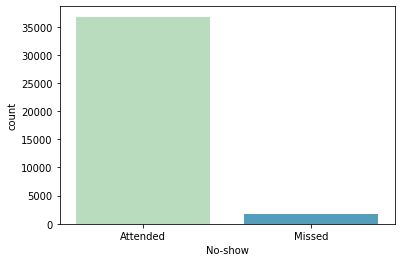

In [17]:
sns.countplot(x='No-show', data = apptMatches, palette = 'GnBu')

To analyze how many appointments from this subset were missed, we can first count the Attended and Missed occurences, and then use those values to find the percentage.

In [18]:
apptMatches['No-show'].value_counts([0])
# .value_counts([0]) normalizes the values

Attended    0.953531
Missed      0.046469
Name: No-show, dtype: float64

From the above cell, we can see that only around 5% of these same day appointments are missed. 

Let's see how this compares to the overall dataset:

In [19]:
df['No-show'].value_counts([0])

Attended    0.798067
Missed      0.201933
Name: No-show, dtype: float64

And how it compares to the dataset when we remove the same-day appointments:

In [20]:
# Create a list of the indeces associated with the same-day appointments
matchIndex = apptMatches.index

# Create a new DataFrame that does not include same-day appointments by dropping rows using the list created above
appts_wo_Matches = df.drop(matchIndex, axis=0)

In [21]:
appts_wo_Matches['No-show'].value_counts([0])

Attended    0.71476
Missed      0.28524
Name: No-show, dtype: float64

Given that the fraction of missed same-day appointments is significantly lower than those missed overall, I would guess that:
1. The same-day appointments were primarily walk-ins
2. The same-day appointments that were missed were likely scheduled over the phone earlier in the day

#### Of the same-day appointments, are more of the missed appointments those that were scheduled earlier in the day?

In [22]:
# Find the range of times that these appointments are scheduled for same-day appointments
apptMatches['Scheduled Time'].describe()

count                         38563
unique                        22119
top       2020-04-29 07:09:54+00:00
freq                             25
first     2020-04-29 06:09:36+00:00
last      2020-04-29 20:44:54+00:00
Name: Scheduled Time, dtype: object

In [23]:
apptMatches['Scheduled Time']

24654   2020-04-29 06:58:16+00:00
19598   2020-04-29 08:01:11+00:00
19595   2020-04-29 07:10:17+00:00
93571   2020-04-29 15:02:27+00:00
93572   2020-04-29 14:37:17+00:00
                   ...           
72317   2020-04-29 07:14:10+00:00
72313   2020-04-29 09:21:51+00:00
72310   2020-04-29 09:00:08+00:00
72305   2020-04-29 07:52:21+00:00
72318   2020-04-29 09:47:12+00:00
Name: Scheduled Time, Length: 38563, dtype: datetime64[ns, UTC]

The earliest appointments are scheduled around 6 am and the latest around 8:45 pm. I want to compare appointments that were scheduled earlier in the day, so from 6 am to 1 pm, to the appointments scheduled afterward. I would guess that more of the same-day appointments that were missed were scheduled earlier in the day.

In [24]:
# Create a DataFrame using the subset of patients who scheduled a same-day appointment early in the day.
earlyMatches = apptMatches[(apptMatches['Scheduled Time'].dt.hour >=6) & (apptMatches['Scheduled Time'].dt.hour <= 12)]
earlyMatches.head(3)

,PatientId,AppointmentID,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Scheduled Date,Scheduled Time,Appointment Date,scheduledDow,Scheduled Day,appointmentDow,Appointment Day
24654,18961433933.0,5697881,F,53,REDENÇÃO,0,0,0,0,1,0,Attended,2016-05-16,2020-04-29 06:58:16+00:00,2016-05-16,0,Monday,0,Monday
19598,93486429157969.0,5742455,F,80,JARDIM CAMBURI,0,0,0,0,0,0,Attended,2016-05-30,2020-04-29 08:01:11+00:00,2016-05-30,0,Monday,0,Monday
19595,2616695597419.0,5643151,F,53,ILHA DO PRÍNCIPE,0,0,0,0,0,0,Missed,2016-05-02,2020-04-29 07:10:17+00:00,2016-05-02,0,Monday,0,Monday


In [25]:
# Double check that the times fall between 6 am and 1 pm
earlyMatches['Scheduled Time'].describe()

count                         28252
unique                        14638
top       2020-04-29 07:09:54+00:00
freq                             25
first     2020-04-29 06:09:36+00:00
last      2020-04-29 12:59:52+00:00
Name: Scheduled Time, dtype: object

In [26]:
earlyMatches['No-show'].value_counts([0])

Attended    0.954552
Missed      0.045448
Name: No-show, dtype: float64

In [27]:
# Create a DataFrame for the appointments scheduled later in the day
lateMatches = apptMatches[(apptMatches['Scheduled Time'].dt.hour >12)]

In [28]:
lateMatches['No-show'].value_counts([0])

Attended    0.950732
Missed      0.049268
Name: No-show, dtype: float64

There actually doesn't appear to be a significant difference in attendance between appointments that were scheduled earlier and later in the day. 

#### Next, I want to visualize appointment attendance based on the day of the week that the appointment is scheduled for.

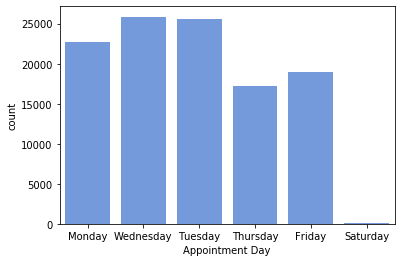

In [29]:
# Plot the distribution of appointments scheduled for each day of the week
sns.countplot(x='Appointment Day', data=df, color = 'cornflowerblue')

The above plot is a little weird with the dates are out of order. Let's change that. 

In [30]:
df = df.sort_values('appointmentDow')
df.head(3)

,PatientId,AppointmentID,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Scheduled Date,Scheduled Time,Appointment Date,scheduledDow,Scheduled Day,appointmentDow,Appointment Day
24654,18961433933.0,5697881,F,53,REDENÇÃO,0,0,0,0,1,0,Attended,2016-05-16,2020-04-29 06:58:16+00:00,2016-05-16,0,Monday,0,Monday
73278,1941491283397.0,5744227,F,54,ILHA DAS CAIEIRAS,1,1,0,0,0,0,Attended,2016-05-30,2020-04-29 09:58:39+00:00,2016-05-30,0,Monday,0,Monday
98498,285389484234444.0,5775475,F,39,SÃO JOSÉ,0,0,0,0,0,0,Attended,2016-06-06,2020-04-29 09:29:26+00:00,2016-06-06,0,Monday,0,Monday


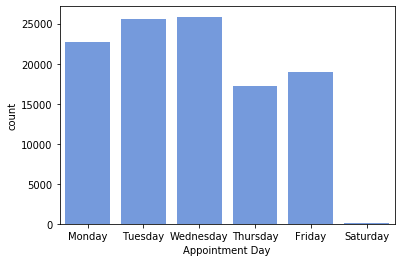

In [34]:
sns.countplot(x='Appointment Day', data=df, color='cornflowerblue')

Now let's find the proportion of appointments that are missed, and while we're at it, let's just analyze the appointments that weren't scheduled for the same day since we've already seen that the vast majority of those appointments are attended. 

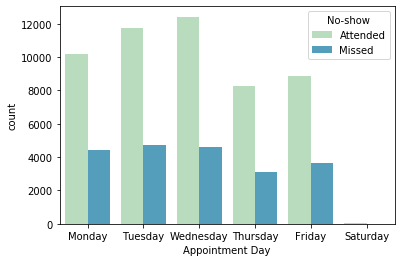

In [32]:
sns.countplot(x='Appointment Day', data=appts_wo_Matches.sort_values('appointmentDow'), palette='GnBu', hue='No-show')

In [44]:
attendancePercentage = appts_wo_Matches.groupby('Appointment Day')['No-show'].value_counts(normalize=True)
attendancePercentage

Appointment Day  No-show 
Friday           Attended    0.706456
                 Missed      0.293544
Monday           Attended    0.697847
                 Missed      0.302153
Saturday         Attended    0.709677
                 Missed      0.290323
Thursday         Attended    0.727265
                 Missed      0.272735
Tuesday          Attended    0.713253
                 Missed      0.286747
Wednesday        Attended    0.728483
                 Missed      0.271517
Name: No-show, dtype: float64

Just from here, we can see that there doesn't appear to be a significant difference in attendance amongst the days. Since we're already this far, we might as well plot the data.

In [45]:
attendancePercentage = attendancePercentage.mul(100).rename('Percent').reset_index()
attendancePercentage.head(2)

,Appointment Day,No-show,Percent
0,Friday,Attended,70.645574
1,Friday,Missed,29.354426


In [46]:
order = df.sort_values('scheduledDow')['Appointment Day'].unique()

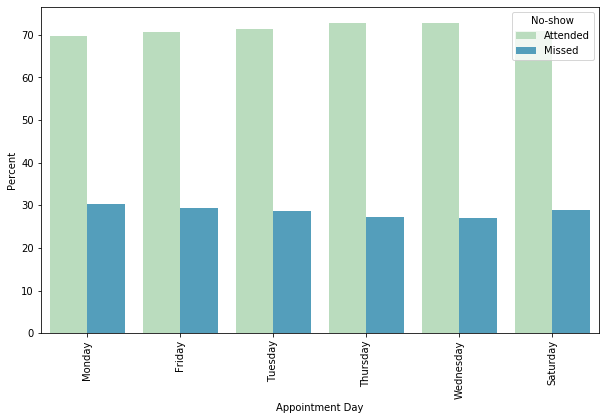

In [47]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Appointment Day', y='Percent', data=attendancePercentage, hue='No-show', palette='GnBu')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

<a id='nb_age'></a>
### 2. The Relationship between a Patient's Age and Attendance

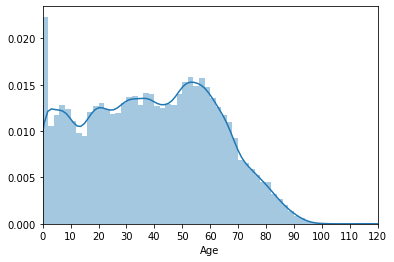

In [62]:
sns.distplot(appts_wo_Matches.Age, bins = np.arange(0, 120, 2))
plt.xlim(0, 120)
plt.xticks(np.arange(0, 120+10, 10));

Right off the bat, we can see that most of these are either obstetric or neonatal appointments.

In [64]:
appts_wo_Matches[appts_wo_Matches['Age'] == 0]['No-show'].value_counts([0])

Attended    0.724073
Missed      0.275927
Name: No-show, dtype: float64

Surprisingly, the fraction of these appointments that are missed matches the fraction of appointments that are missed overall. I would have expected this fraction to be far smaller. Again, we are only looking at appointments that are not same-day appointments. 

Next, let's find the ages of the patients from each neighborhood and see if we can find any relationship between patient age and appointment attendance.

In [65]:
# Counts how many appointments were scheduled for each neighborhood
nb = appts_wo_Matches['Neighbourhood'].value_counts()
nb.head(3)

JARDIM CAMBURI    5213
MARIA ORTIZ       3730
RESISTÊNCIA       2819
Name: Neighbourhood, dtype: int64

In [66]:
nb.describe()

count      80.000000
mean      899.550000
std       888.584152
min         2.000000
25%       281.500000
50%       642.000000
75%      1361.000000
max      5213.000000
Name: Neighbourhood, dtype: float64

Above, we see that the data is right-skewed

In [67]:
# Create a list that only includes neighborhoods where the number of appointments scheduled are above the median
nb_list = list(nb[nb > 851].index)

In [68]:
# Create a DataFrame that only includes neighborhoods that surpass your threshold for analysis
nb_df = appts_wo_Matches[appts_wo_Matches['Neighbourhood'].isin(nb_list)]

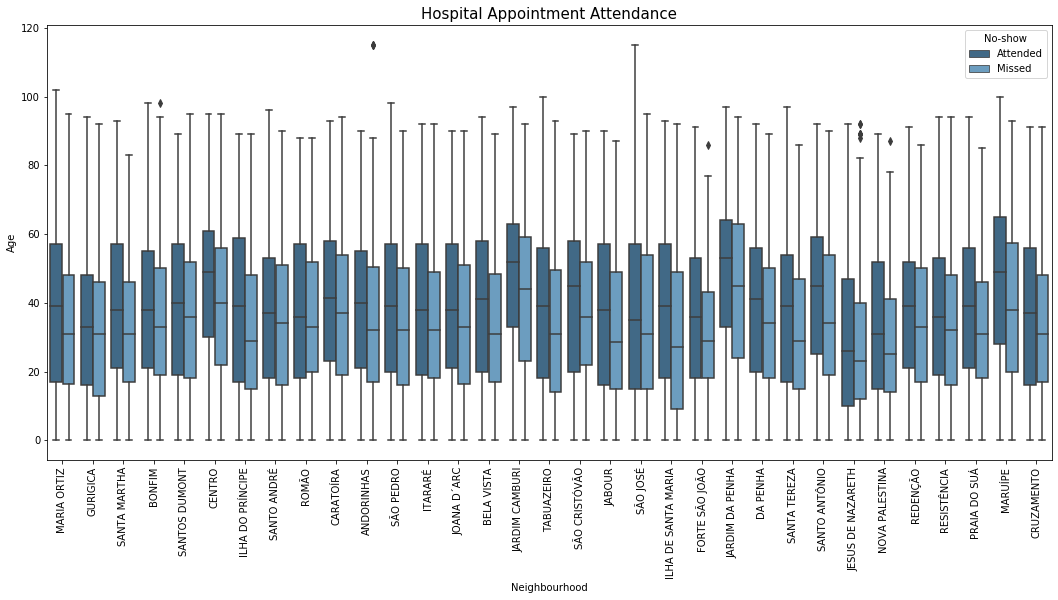

In [69]:
plt.figure(figsize=(18,8))
ax = sns.boxplot(x='Neighbourhood', y='Age', data=nb_df, palette="Blues_d", hue='No-show')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Hospital Appointment Attendance', fontsize=15)
plt.show()

Here, we see that patients who miss their appointments tend to be younger than those who attend their appointments. Next, we should do the same but only include patients who are older than 20. I would assume that by that age, most patients are able to drive themselves or take public transportation to the hospital independently.

In [70]:
olderPatients = nb_df[nb_df['Age']>=20]

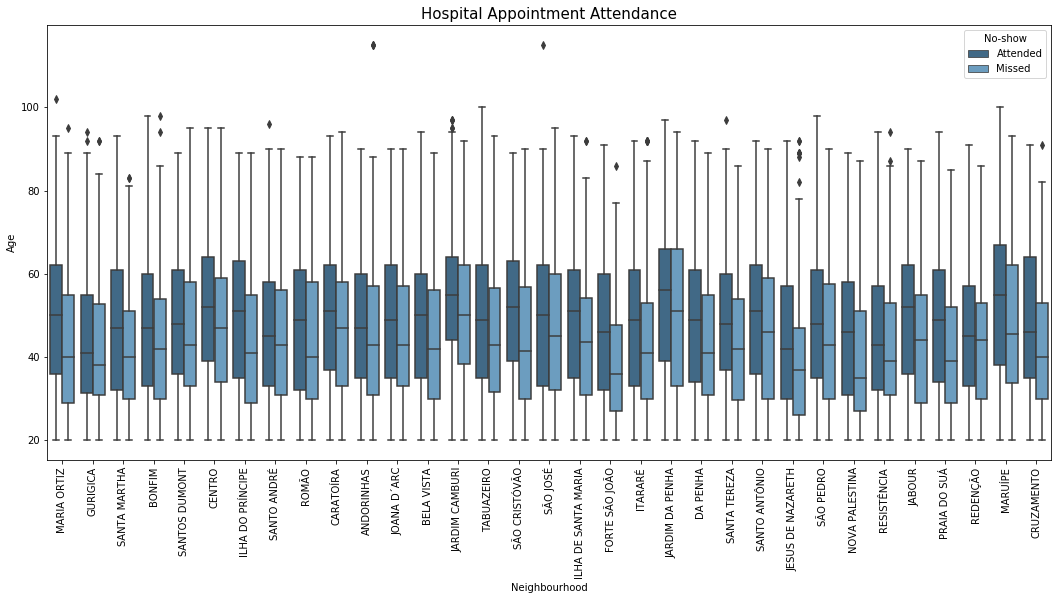

In [71]:
plt.figure(figsize=(18,8))
ax = sns.boxplot(x='Neighbourhood', y='Age', data=olderPatients, palette="Blues_d", hue='No-show')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Hospital Appointment Attendance', fontsize=15)
plt.show()

Even when removing the younger patients, the trend still persists. Those who miss their appointments do in fact tend to be younger.

In [72]:
youngerPatients = nb_df[nb_df['Age']<20]

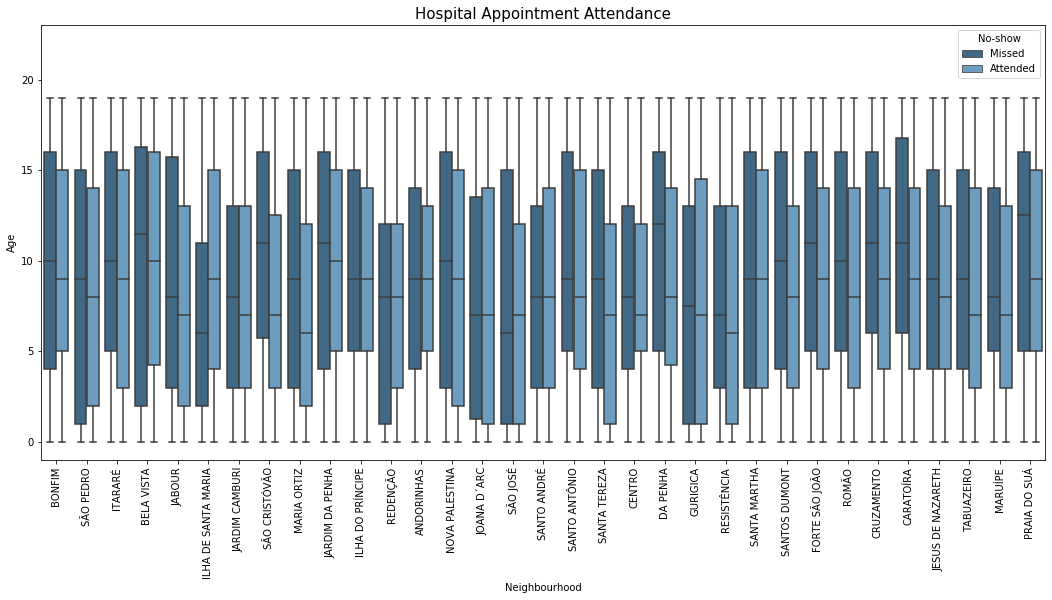

In [75]:
plt.figure(figsize=(18,8))
ax = sns.boxplot(x='Neighbourhood', y='Age', data=youngerPatients, palette="Blues_d", hue='No-show')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Hospital Appointment Attendance', fontsize=15)
plt.ylim(-1, 23)
plt.show()

As one would expect, the results for younger patients are far more mixed. Most of these patients depend on some sort of guardian to bring them to their appointment, so whether or not they attend is less a function of the patient's age than it would be for those who are older.

<a id='conclusions'></a>
## Conclusions

`Limitations`

This hospital dataset was extensive, including more than 100,000 scheduled appointments in 81 different neighborhoods for 62,299 different patients. There was also a sizeable representation of each age group for these appointments. While these factors contribute to the power of this dataset, it is important to note that these appointment were only recorded for a little over a month. There may be seasonal differences in patient behavior, which could alter the conclusions that we have found in this dataset. Additionally, Brazil's population is around 200 million. Seeing that our dataset only includes information on an infinitesimal fraction of the Brazilian population, our dataset might also mask patient behaviors that otherwise would be manifest in a larger data collection. 

`Findings`

In exploring this dataset, we found that most people do in fact attend the appointments they schedule for themselves. This truth holds true even when we remove patients whom we can only assume were walk-ins. We also found that there didn't seem to be a relationship between the day of the week that the appointment was scheduled for and attendance. However, there did seem to be a relationship between age and patient attendance. When comparing the median age of patients who attend and miss their appointments, we see that patients who miss their appointments tend to be younger.


```
```